# Setup

In [5]:
# Only run once
#!pip install librosa
#!pip install tensorflow

In [5]:
# Package Imports
import sys
# sys.path.append('/Users/sucheen/anaconda3/lib/python3.11/site-packages')
sys.path.append('/Users/sophiapchung/anaconda3/lib/python3.10/site-packages')
import pandas as pd
import numpy as np
import librosa
from scipy.io import wavfile
import soundfile as sf
import glob
import os
import boto3
import tensorflow as tf
from awsKeys import awsKeys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



KEYS = "ssundar_accessKeys.csv" # change to your path
# KEYS = '/Users/sophiapchung/Desktop/Bioacoustics/spchung_accessKeys.csv'

aws_access_key_id, aws_secret_access_key = awsKeys(KEYS)

# Create a boto3 resource with your credentials
s3 = boto3.resource(
    's3',
    region_name='us-west-2',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
)

# S3 Bucket for Professor's Account is 'monitoring-whale-recordings'
# S3 Bucket for our free tier Account is 'monitoring-whale-records'
bucket_name = 'whale-recordings'
bucket = s3.Bucket(bucket_name)


## CONSTANTS
# Window size (n_fft) in seconds
WINDOW_SIZE_SEC = 0.15175
# Hop Length in seconds
HOP_LEN_SEC = 0.05
# Decimated .wav files w/ their file path
WAV_FILES = []
for file in bucket.objects.all():
    if file.key.split('/')[-2] == 'decimated_files':
        wav = file.key.split('/')[-1] 
        path = file.key
        if wav != '':
            WAV_FILES.append([wav, path])

# Reading .wav Files

In [6]:
def read_wavfile(wname, verbose=False):
    """
    Reads in a decimated wav file from the S3 Bucket.
    
    PARAMETERS
    ----------
        wname: string
            Decimated WAV file's name
        verbose: boolean
            Indicates whether or not to make output excessively detailed
    ----------
    
    RETURNS
    ----------
        sr: int
            Sampling rate of WAV file
        data: numpy array
            Contains floats representing the amplitudes of the sound wave for each sample (automatically ordered from earliest to latest)
    ----------
    """
    # Reads-in the decimated WAV file's information.
    """try:
        #sr, data = wavfile.read(wname) # NOTE: Sampling rate (sr) seems to be 8000 samples per second
        # download the file with the given name
        bucket.download_file(wname, wname)
        sr, data = wavfile.read(wname)
    except Exception:
        print(f'{wname} not found')
        exit(1)"""
    # download the file with the given name
    #bucket.download_file(wname, wname)
    sr, data = wavfile.read(f'{wname}')
    if verbose:
        print(f'{wname}: {data.shape[0]} samples at {sr} samples/sec --> {data.shape[0]/sr} seconds')
    
    return sr, data

# STFT --> Mel --> PCEN Implementation

In [1]:
import librosa
import numpy as np
import tensorflow as tf

def process_wav(wname, target_shape=(608, 192), verbose=True, batch_size=30, running=False):
    """
    Processes a WAV file by converting it to a Mel-Spectrogram and then to PCEN.
    :param wname: wav file name
    :param target_shape: target shape of the spectrogram
    :param verbose: verbosity
    :param batch_size: batch size
    :param running: running mode
    :return: dataset & sampling rate
    """
    data, sr = librosa.load(wname, sr=None, mono=True)
    if verbose:
        print(f"Loaded {wname} with sample rate {sr}")

    # Convert to Mel-Spectrogram and then to PCEN
    S = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=2048, hop_length=512, n_mels=target_shape[1])
    S_DB = librosa.power_to_db(S, ref=np.max)
    S_PCEN = librosa.pcen(S * (2**31), sr=sr, hop_length=512)

    # Transpose to align time and frequency axes
    S_PCEN = np.transpose(S_PCEN, (1, 0))
    if verbose:
        print("Shape after transpose:", S_PCEN.shape)

    # Segment the long spectrogram into smaller chunks
    segmented_spectrograms = []
    for start in range(0, S_PCEN.shape[0] - target_shape[0] + 1, target_shape[0]):
        segmented = S_PCEN[start:start + target_shape[0], :]
        if segmented.shape[0] == target_shape[0]:
            segmented_spectrograms.append(segmented.reshape(target_shape[0], target_shape[1], 1))
    if verbose:
        print(f"Generated {len(segmented_spectrograms)} segments of shape {target_shape}.")

    if running:
        return np.array(segmented_spectrograms), sr

    dataset = tf.data.Dataset.from_tensor_slices(np.array(segmented_spectrograms))
    dataset = dataset.shuffle(buffer_size=100).batch(batch_size)
    return dataset, sr


2024-05-04 17:21:01.547910: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 17:21:01.547942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 17:21:01.549065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 17:21:01.555820: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 17:21:02.351842: W tensorflow/comp

# Copy Files to S3 Bucket

In [8]:
def copy_to_bucket(fileSource, fileDestination):
    """
    Copies a file from this notebook's working directory to the S3 Bucket.
    :param fileSource: string
        Name of the file to be copied
    :param fileDestination: string
        Name of the file in the S3 Bucket
    """
    # NOTE: Change the following name of the S3 Bucket (in parentheses) to reflect the name of the S3 Bucket for your current AWS account.
    """WARNING: This S3 Bucket should be the one that contains SageMaker files (NOT the one with WAV files and TXT files)."""
    write_bucket = s3.Bucket('sagemaker-us-west-2-9')
    write_bucket.upload_file(fileSource, fileDestination)
print("finished preprocessing")

finished preprocessing



# Mel Spectrogram - between STFT and PCEN

/var/folders/mh/b5m2p8fd04x2knz5_hwd1rqw0000gn/T/ipykernel_4722/763813430.py:6: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(sgram)


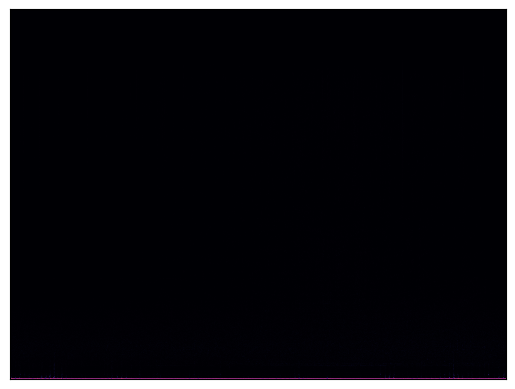

In [9]:
# AUDIO_FILE = "files/6805.230201090825_processed.wav"
# samples, sample_rate = librosa.load(AUDIO_FILE, sr=None)

# # # raw frequency
# sgram = librosa.stft(samples)
# librosa.display.specshow(sgram)

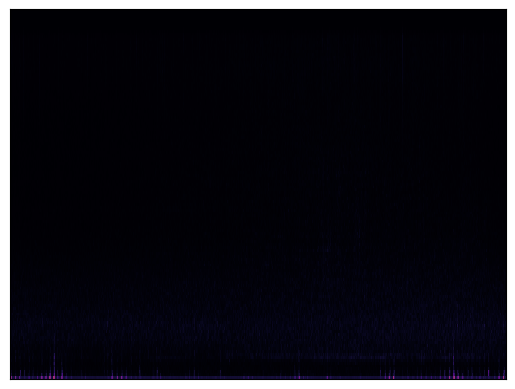

In [10]:
# mel-scale instead of frequency of Hz
# sgram_mag, _ = librosa.magphase(sgram)
# mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
# librosa.display.specshow(mel_scale_sgram)